In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import seaborn as sns

import os
import pickle

from copy import deepcopy

import time

import tqdm

In [2]:
from matplotlib import gridspec
def create_subtitle(fig: plt.Figure, grid: gridspec.SubplotSpec, title: str, fontsize: int=16):
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=fontsize)
    #row.set_title(f'{title}\n')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [3]:
#outdir = '../../output/experiment'
outdir = './output/synthetic/univariate/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Sample sequences

In [4]:
def generate_data(N, pi, mu, sigma):
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, 1))
    for i, z in enumerate(z_list):
        X_i = np.random.normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

In [5]:
def add_subplot_axes(ax, rect, axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    subax = fig.add_axes([x, y, width, height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
        
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)

    return subax

In [6]:
N = 10000
alpha_ol = 0.01
pi = np.array([0.5, 0.5])
mu1 = np.array([0.5, -0.5])
mu2 = np.array([1.0, -1.0])
sigma = np.array([0.1, 0.1])
cps = np.array([9999])

u = 20

In [7]:
np.random.seed(0)
X_abrupt = np.zeros((2*N, 1))
Xj_former = generate_data(N, pi, mu1, sigma)
X_abrupt[:N, 0] = Xj_former.ravel()
Xj_latter = generate_data(N, pi, mu2, sigma)
X_abrupt[N:, 0] = Xj_latter.ravel()

#idxes_ol = np.random.choice(np.arange(N), int(alpha_ol*N))
idxes_ol_abrupt = np.random.choice(np.arange(2*N), int(alpha_ol*2*N))
X_abrupt[idxes_ol_abrupt, :] = np.random.uniform(-u, u, len(idxes_ol_abrupt)).reshape(-1, 1)    

In [8]:
np.random.seed(1)
X_gradual = np.zeros((2*N, 1))
Xj_former = generate_data(N, pi, mu1, sigma)
X_gradual[:N, 0] = Xj_former.ravel()
#Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
Xj_trans = np.hstack([ generate_data(1, pi, mu1 + (t-N+1)/300 * (mu2-mu1), sigma) for t in range(N, N+300) ])
X_gradual[N:(N+300), 0] = Xj_trans
Xj_latter = generate_data(N-300, pi, mu2, sigma)
X_gradual[N+300:, 0] = Xj_latter.ravel()

#idxes_ol = np.random.choice(np.arange(N), int(alpha_ol*N))
idxes_ol_gradual = np.random.choice(np.arange(2*N), int(alpha_ol*2*N))
X_gradual[idxes_ol_gradual, :] = np.random.uniform(-u, u, len(idxes_ol_gradual)).reshape(-1, 1)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


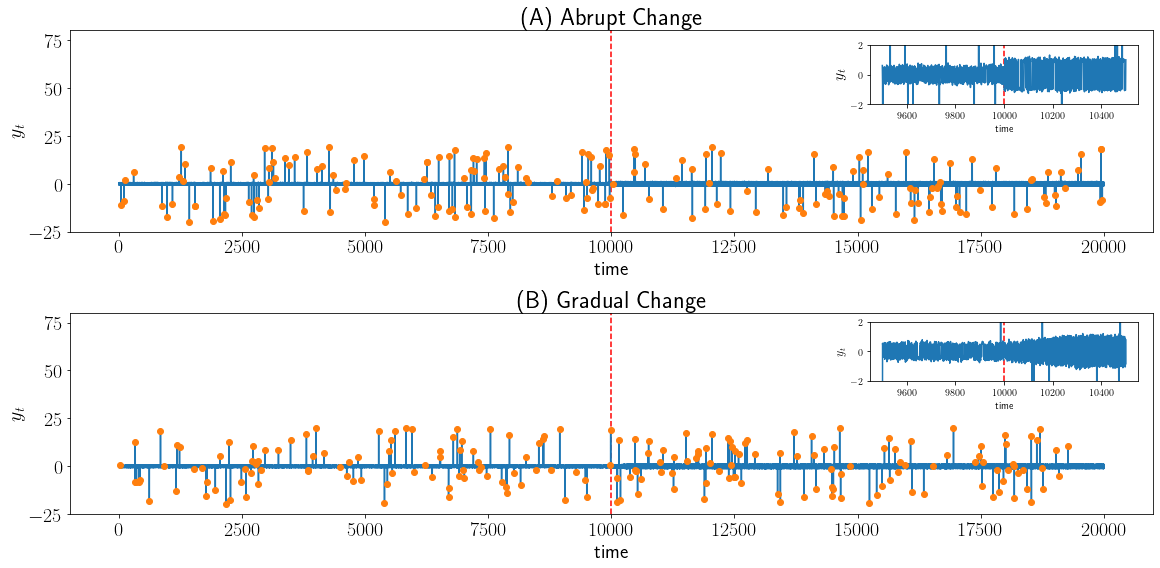

In [12]:
times = np.arange(1, 2*N+1)
rect1 = [0.8, 0.8, 0.3, 0.3]
rect2 = [0.8, 0.6, 0.3, 0.3]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(16, 8))

axes[0].plot(times, X_abrupt.ravel())
axes[0].plot(times[idxes_ol_abrupt], X_abrupt.ravel()[idxes_ol_abrupt], marker='o', linestyle='None')
axes[0].axvline(10000, linestyle='dashed', color='red', zorder=1)
axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0].set_ylim(-25, 80)
axes[0].set_xlabel('time', fontsize=20)
axes[0].set_ylabel(r'$y_{t}$', fontsize=20)
axes[0].set_title('(A) Abrupt Change', fontsize=24)
axes[0].tick_params(labelsize=20)

subax0 = add_subplot_axes(axes[0], rect1)
subax0.plot(np.arange(9500, 10501), X_abrupt.ravel()[9499:10500])
subax0.axvline(10000, linestyle='dashed', color='red', zorder=1)
subax0.set_ylim(-2, 2)
subax0.set_xlabel('time', fontsize=10)
subax0.set_ylabel(r'$y_{t}$', fontsize=16)
subax0.tick_params(labelsize=10)

axes[1].plot(times, X_gradual.ravel())
axes[1].plot(times[idxes_ol_gradual], X_gradual.ravel()[idxes_ol_gradual], marker='o', linestyle='None')
axes[1].axvline(10000, linestyle='dashed', color='red', zorder=1)
axes[1].set_ylim(-25, 80)
axes[1].set_xlabel('time', fontsize=20)
axes[1].set_ylabel(r'$y_{t}$', fontsize=20)
axes[1].set_title('(B) Gradual Change', fontsize=24)
axes[1].tick_params(labelsize=20)

subax1 = add_subplot_axes(axes[1], rect2)
subax1.plot(np.arange(9500, 10501), X_gradual.ravel()[9499:10500])
subax1.axvline(10000, linestyle='dashed', color='red', zorder=1)
subax1.set_ylim(-2, 2)
subax1.set_xlabel('time', fontsize=10)
subax1.set_ylabel(r'$y_{t}$', fontsize=12)
subax1.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'plot_sample_sequence_univariate_synthetic_datasets.pdf'), bbox_inches='tight', dpi=200)

# Computation time

In [12]:
with open('./output/synthetic/univariate/abrupt_single/measured_total_time_by_algorithm.pkl', 'rb') as f:
    measured_total_time_by_algorithm_abrupt_single = pickle.load(f)
    
with open('./output/synthetic/univariate/abrupt_mixture/measured_total_time_by_algorithm.pkl', 'rb') as f:
    measured_total_time_by_algorithm_abrupt_mixture = pickle.load(f)

with open('./output/synthetic/univariate/gradual_single/measured_total_time_by_algorithm.pkl', 'rb') as f:
    measured_total_time_by_algorithm_gradual_single = pickle.load(f)

with open('./output/synthetic/univariate/gradual_mixture/measured_total_time_by_algorithm.pkl', 'rb') as f:
    measured_total_time_by_algorithm_gradual_mixture = pickle.load(f)

In [17]:
with open('./output/synthetic/univariate/abrupt_single/measured_each_time_by_algorithm.pkl', 'rb') as f:
    measured_each_time_by_algorithm_abrupt_single = pickle.load(f)
    
with open('./output/synthetic/univariate/abrupt_mixture/measured_each_time_by_algorithm.pkl', 'rb') as f:
    measured_each_time_by_algorithm_abrupt_mixture = pickle.load(f)

with open('./output/synthetic/univariate/gradual_single/measured_each_time_by_algorithm.pkl', 'rb') as f:
    measured_each_time_by_algorithm_gradual_single = pickle.load(f)

with open('./output/synthetic/univariate/gradual_mixture/measured_each_time_by_algorithm.pkl', 'rb') as f:
    measured_each_time_by_algorithm_gradual_mixture = pickle.load(f)

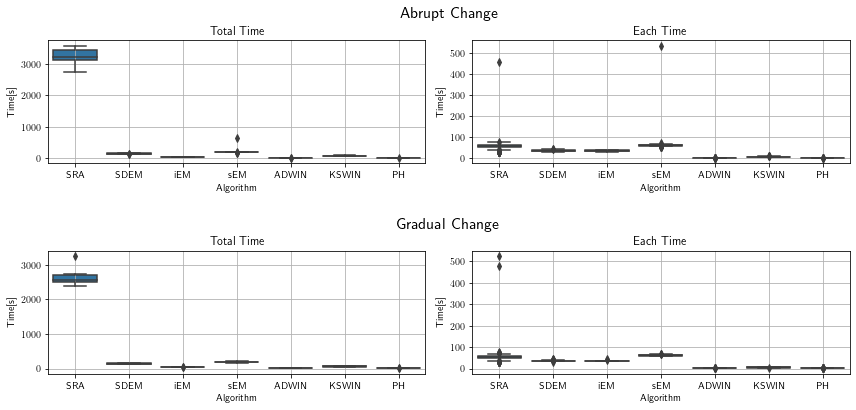

In [83]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 6))

# abrupt/mixture
sns.boxplot(x='variable', y='value', data=measured_total_time_by_algorithm_abrupt_mixture, ax=axes[0, 0])
axes[0, 0].set_title('Total Time')
axes[0, 0].set_xlabel('Algorithm')
axes[0, 0].set_ylabel('Time[s]')
axes[0, 0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0, 0].grid(zorder=1)

sns.boxplot(x='Algorithm', y='Time', data=measured_each_time_by_algorithm_abrupt_mixture, ax=axes[0, 1])
axes[0, 1].set_title('Each Time')
axes[0, 1].set_ylabel('Time[s]')
axes[0, 1].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0, 1].grid(zorder=1)

# gradual/mixture
sns.boxplot(x='variable', y='value', data=measured_total_time_by_algorithm_gradual_mixture, ax=axes[1, 0])
axes[1, 0].set_title('Total Time')
axes[1, 0].set_xlabel('Algorithm')
axes[1, 0].set_ylabel('Time[s]')
axes[1, 0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[1, 0].grid(zorder=1)

sns.boxplot(x='Algorithm', y='Time', data=measured_each_time_by_algorithm_gradual_mixture, ax=axes[1, 1])
axes[1, 1].set_title('Each Time')
axes[1, 1].set_ylabel('Time[s]')
axes[1, 1].grid(zorder=1)

grid = plt.GridSpec(2, 2)
create_subtitle(fig, grid[0, ::], 'Abrupt Change')
create_subtitle(fig, grid[1, ::], 'Gradual Change')

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'summary_measured_time_by_algorithm_synthetic_univariate.pdf'), 
            bbox_inches='tight', dpi=300)

# Dependency on Hyperparamters

In [13]:
with open('./output/synthetic/univariate/abrupt_mixture/auc_sra.pkl', 'rb') as f:
    auc_sra_df_abrupt = pickle.load(f)
    
with open('./output/synthetic/univariate/gradual_mixture/auc_sra.pkl', 'rb') as f:
    auc_sra_df_gradual = pickle.load(f)

In [14]:
auc_sra_df = pd.concat([auc_sra_df_abrupt, auc_sra_df_gradual], axis=1)

In [15]:
auc_sra_df.to_latex('./output/synthetic/univariate/auc_sra_1D_mixture.tex', float_format='%.3f')